In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

In [2]:
df = pd.read_csv("sydney_traffic_incidents_clean.csv")  # adjust path if needed
print("Shape:", df.shape)
df.head()

Shape: (82624, 84)


,Main_Category,Longitude,Latitude,Day,duration,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Advice_B,Closure_Type,Direction,Main_Street,Affected_Lanes,Actual_Number_of_Lanes,Suburb,Traffic_Volume,SA2_CODE21,SA3_NAME21,AREASQKM21,2_ML,3_TRL,4_PRL,5_SRL,6_TrRL,7_RRL,8_LsRL,9_URL,10_ToRL,11_EoR,12_NoN,13_NDEs,14_NNC2L,15_NNC3L,16_NNC4L,17_AND,18_NE,19_MCI,20_CoI,21 NBS,22_CA,23_EA,24_HA,25_IA,26_OA,27_PA,28_PrA,29_RA,30_TA,31_WbA,32_EoLU,33_TP,34_PD0MV,35_PD1MV,36_PD2MV,37_PD3MV,38_PD≥4MV,39_PUE,40_AMI,41_NPTtWbyPT,42_NPTtWbyTx,43_NPTtWbyCD,44_NPTtWbyCP,45_NPTtWbyO,46_NPWfH,47_PWCJH,48_PBCJH,49_ANP_FH,RMS,Motorway Crew,Mechanic,Emergency service(s),Tow Truck,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD,duration_class
0,1,151.058,-33.9431,5,39.319950,1,2,0,10,0,0,3,1680,99,99,841,3,119021366,11,5.2458,7.488104,3.038780,2.236683,6.602571,2.551265,42.103090,0.0,0.115587,64.136080,0.504771,325,40,7,260,17,2.790769,491,0.258915,0.001351,210,0.0938,0.1211,0.0000,0.7056,0.0,0.5171,0.0,3.8082,0.0000,0.0,0.386385,21537,11.297837,37.886855,30.565724,12.296173,7.953411,12.109393,831,342,16,2806,276,260,1520,67.634460,32.365540,3.713468,0,0,0,0,0,0,1,0,0,0,0,2,8,19,15.781064,1
1,0,151.159,-33.8096,6,12.029000,1,9,0,10,134,2,8,1343,1,2,535,3,121011399,13,5.5372,8.365015,2.097842,7.903368,4.617769,0.232704,40.351141,0.0,0.739679,64.307518,0.515889,269,59,6,176,28,2.643123,383,0.215760,0.001839,210,0.0080,0.1223,0.0238,0.0000,0.0,1.3725,0.0,4.0106,0.0000,0.0,0.302463,21270,10.253288,52.715538,29.067219,5.723332,2.240623,7.776211,1643,651,6,2652,227,514,6070,88.007396,11.992604,3.023239,0,1,0,0,0,0,0,0,0,0,1,1,8,0,8.323913,0
2,1,150.875,-33.7344,6,16.956667,1,9,0,26,134,2,8,2845,1,1,810,3,116011304,3,7.3828,9.051683,0.000000,12.307502,5.297219,9.525819,56.104489,0.0,0.128916,92.415628,0.523895,468,112,2,307,47,2.617521,631,0.176155,0.001177,234,0.0000,0.2768,0.0000,0.3180,0.0,0.9027,0.0,5.6929,0.1924,0.0,0.352217,20570,8.724832,41.000610,34.716290,10.600976,4.957291,9.688867,1030,532,18,3686,323,256,2398,67.554766,32.445234,3.341706,0,1,0,0,0,0,1,0,0,0,0,1,8,1,34.354983,0
3,1,150.973,-33.8172,6,42.804117,5,2,0,10,0,0,8,1537,1,1,901,2,125041589,31,3.9355,9.698544,8.941532,0.016410,1.416884,5.140331,32.486126,0.0,0.512046,58.211873,0.547443,266,39,7,188,31,2.804511,402,0.259962,0.001650,174,0.1010,0.1006,0.0236,0.0000,0.0,0.2426,0.0,3.1727,0.2950,0.0,0.329226,21564,13.219616,56.830135,22.857143,4.804549,2.288557,9.956409,1302,902,11,2707,291,311,4379,78.956666,21.043334,3.248887,0,0,0,0,0,0,1,1,0,0,0,1,8,1,22.500677,1
4,1,150.981,-33.7919,6,40.840000,3,4,0,10,134,0,7,2059,99,99,742,3,125041493,31,7.4795,0.000000,9.092391,0.000000,7.092430,13.338771,51.982067,0.0,4.266734,85.772393,0.515169,454,105,3,322,23,2.585903,598,0.160576,0.001272,194,0.4036,0.1788,0.0000,0.0000,0.0,0.8217,0.0,6.0754,0.0000,0.0,0.285901,22840,8.134605,39.745628,35.466349,10.996290,5.657128,9.071804,1170,589,18,3487,314,261,3798,77.384802,22.615198,3.295874,0,0,0,0,1,0,0,0,0,0,0,3,8,1,22.753003,1


In [3]:
y = df["duration_class"]
X = df.drop(columns=["duration_class", "duration"])

print("Features:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))


Features: (82624, 82)
Target distribution:
duration_class
0    0.519389
1    0.480611
Name: proportion, dtype: float64


In [4]:
# as with other linear models we will drop high cardinality columns
# Decision Tree can possibly handle them, but there is a danger of overfitting
numeric_cols = X.select_dtypes(include=["float64", "float32"]).columns.tolist()

int_cols = X.select_dtypes(include=["int64", "int32"]).columns.tolist()

cardinality = X[int_cols].nunique().sort_values()

low_cardinality = [c for c in int_cols if X[c].nunique() <= 50]
high_cardinality = [c for c in int_cols if X[c].nunique() > 50]

print("Low-cardinality categorical:", low_cardinality[:10])
print("High-cardinality to drop:", high_cardinality[:10])

X_filtered = X.drop(columns=high_cardinality)
X_filtered.head()

Low-cardinality categorical: ['Main_Category', 'Day', 'Primary_Vehicle', 'Secondary_Vehicle', 'Is_Major_Incident', 'Advice_A', 'Closure_Type', 'Direction', 'Affected_Lanes', 'Actual_Number_of_Lanes']
High-cardinality to drop: ['Advice_B', 'Main_Street', 'Suburb', 'SA2_CODE21', '12_NoN', '13_NDEs', '15_NNC3L', '16_NNC4L', '18_NE', '21 NBS']


,Main_Category,Longitude,Latitude,Day,Primary_Vehicle,Secondary_Vehicle,Is_Major_Incident,Advice_A,Closure_Type,Direction,Affected_Lanes,Actual_Number_of_Lanes,Traffic_Volume,SA3_NAME21,AREASQKM21,2_ML,3_TRL,4_PRL,5_SRL,6_TrRL,7_RRL,8_LsRL,9_URL,10_ToRL,11_EoR,14_NNC2L,17_AND,19_MCI,20_CoI,22_CA,23_EA,24_HA,25_IA,26_OA,27_PA,28_PrA,29_RA,30_TA,31_WbA,32_EoLU,34_PD0MV,35_PD1MV,36_PD2MV,37_PD3MV,38_PD≥4MV,39_PUE,42_NPTtWbyTx,47_PWCJH,48_PBCJH,49_ANP_FH,RMS,Motorway Crew,Mechanic,Emergency service(s),Tow Truck,Motorway crew,Emergency services,Transport for NSW,Tow truck,Heavy vehicle tow truck,Incident_Type,Num_Vehicles_Involved,Month,Hour,distance_to_CBD
0,1,151.058,-33.9431,5,1,2,0,10,0,3,99,99,3,11,5.2458,7.488104,3.038780,2.236683,6.602571,2.551265,42.103090,0.0,0.115587,64.136080,0.504771,7,2.790769,0.258915,0.001351,0.0938,0.1211,0.0000,0.7056,0.0,0.5171,0.0,3.8082,0.0000,0.0,0.386385,11.297837,37.886855,30.565724,12.296173,7.953411,12.109393,16,67.634460,32.365540,3.713468,0,0,0,0,0,0,1,0,0,0,0,2,8,19,15.781064
1,0,151.159,-33.8096,6,1,9,0,10,2,8,1,2,3,13,5.5372,8.365015,2.097842,7.903368,4.617769,0.232704,40.351141,0.0,0.739679,64.307518,0.515889,6,2.643123,0.215760,0.001839,0.0080,0.1223,0.0238,0.0000,0.0,1.3725,0.0,4.0106,0.0000,0.0,0.302463,10.253288,52.715538,29.067219,5.723332,2.240623,7.776211,6,88.007396,11.992604,3.023239,0,1,0,0,0,0,0,0,0,0,1,1,8,0,8.323913
2,1,150.875,-33.7344,6,1,9,0,26,2,8,1,1,3,3,7.3828,9.051683,0.000000,12.307502,5.297219,9.525819,56.104489,0.0,0.128916,92.415628,0.523895,2,2.617521,0.176155,0.001177,0.0000,0.2768,0.0000,0.3180,0.0,0.9027,0.0,5.6929,0.1924,0.0,0.352217,8.724832,41.000610,34.716290,10.600976,4.957291,9.688867,18,67.554766,32.445234,3.341706,0,1,0,0,0,0,1,0,0,0,0,1,8,1,34.354983
3,1,150.973,-33.8172,6,5,2,0,10,0,8,1,1,2,31,3.9355,9.698544,8.941532,0.016410,1.416884,5.140331,32.486126,0.0,0.512046,58.211873,0.547443,7,2.804511,0.259962,0.001650,0.1010,0.1006,0.0236,0.0000,0.0,0.2426,0.0,3.1727,0.2950,0.0,0.329226,13.219616,56.830135,22.857143,4.804549,2.288557,9.956409,11,78.956666,21.043334,3.248887,0,0,0,0,0,0,1,1,0,0,0,1,8,1,22.500677
4,1,150.981,-33.7919,6,3,4,0,10,0,7,99,99,3,31,7.4795,0.000000,9.092391,0.000000,7.092430,13.338771,51.982067,0.0,4.266734,85.772393,0.515169,3,2.585903,0.160576,0.001272,0.4036,0.1788,0.0000,0.0000,0.0,0.8217,0.0,6.0754,0.0000,0.0,0.285901,8.134605,39.745628,35.466349,10.996290,5.657128,9.071804,18,77.384802,22.615198,3.295874,0,0,0,0,1,0,0,0,0,0,0,3,8,1,22.753003


In [5]:
# split into train/test

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

X_train.shape, X_test.shape

((66099, 65), (16525, 65))

In [6]:
# basically using defaults here

tree_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
)

start_time = time.time()
tree_clf.fit(X_train, y_train)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 0.58 seconds


In [7]:
# prediction and analysis

y_pred = tree_clf.predict(X_test)
y_proba = tree_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6536762481089259

Classification report:

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      8520
           1       0.65      0.63      0.64      8005

    accuracy                           0.65     16525
   macro avg       0.65      0.65      0.65     16525
weighted avg       0.65      0.65      0.65     16525



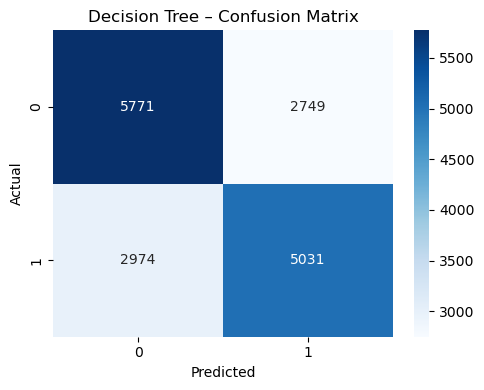

In [8]:
# plot the confusion matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [9]:
# find most important features

importances = pd.Series(
    tree_clf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("Top 15 features by tree importance:")
print(importances.head(15))

Top 15 features by tree importance:
Affected_Lanes             0.170558
Primary_Vehicle            0.152144
Traffic_Volume             0.123403
Secondary_Vehicle          0.064146
Main_Category              0.056681
38_PD≥4MV                  0.051298
Hour                       0.045139
2_ML                       0.024103
49_ANP_FH                  0.022845
Is_Major_Incident          0.022074
Transport for NSW          0.020724
Num_Vehicles_Involved      0.017914
distance_to_CBD            0.016520
Heavy vehicle tow truck    0.015721
35_PD1MV                   0.015132
dtype: float64


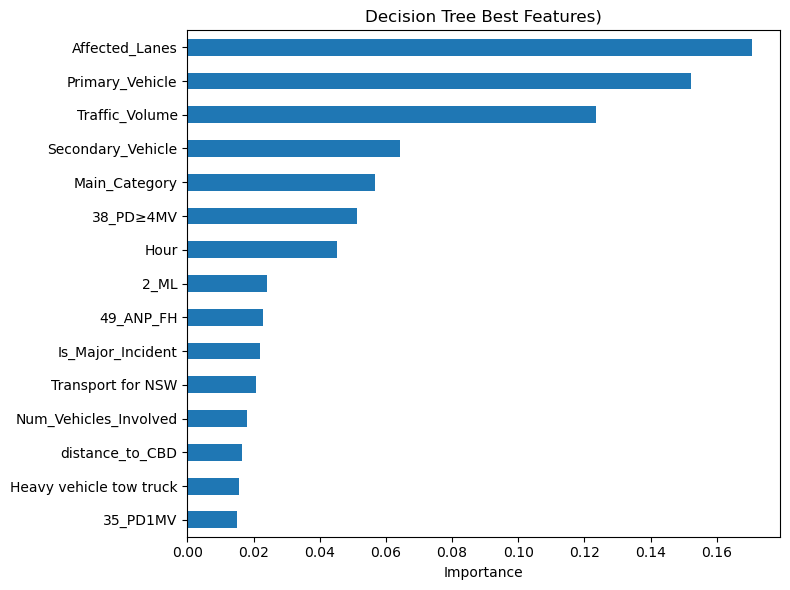

In [11]:
# bar chart of the features

top = importances.head(15).sort_values()

plt.figure(figsize=(8, 6))
top.plot(kind="barh")
plt.title("Decision Tree Best Features)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()